In [1]:
import matplotlib.pyplot as plt
import numpy as np


import sys
sys.path.append('../')

from src import Dataset
from src.covariance import compute_cov, compute_edge_dist
import sklearn

### Loading dataset

In [2]:
# Loads raw data, and processes it if not already processed
dataset = Dataset('../data', force_process=False)

Found processed pickle. Loading from '../data/processed/dataset.pkl'.


### Aggregating cell types

In [12]:
# List cell types
print(dataset.cell_type_labels)
print('Before aggregation: Number of cell types -', dataset.num_cell_types)

# this dict defines how cell types are grouped
aggr_dict = {'e23Cux2': 'e23', 'i5Sst': 'i5Sst', 'i5Htr3a': 'i5Htr3a', 'e4Scnn1a': 'e4', 'e4Rorb': 'e4',
             'e4other': 'e4', 'e4Nr5a1': 'e4', 'i6Htr3a': 'i6Htr3a', 'i6Sst': 'i6Sst', 'e6Ntsr1': 'e6',
             'i23Pvalb': 'i23Pvalb', 'i23Htr3a': 'i23Htr3a', 'i1Htr3a': 'i1Htr3a', 'i4Sst': 'i4Sst', 'e5Rbp4': 'e5',
             'e5noRbp4': 'e5', 'i23Sst': 'i23Sst', 'i4Htr3a': 'i4Htr3a', 'i6Pvalb': 'i6Pvalb', 'i5Pvalb': 'i5Pvalb',
             'i4Pvalb': 'i4Pvalb'}

dataset.aggregate_cell_classes(aggr_dict)
print('After aggregation: Number of cell types -', dataset.num_cell_types)

['e5Rbp4', 'e23Cux2', 'i6Pvalb', 'e4Scnn1a', 'i23Pvalb', 'i6Htr3a', 'i23Htr3a', 'e4Rorb', 'i5Htr3a', 'e4other', 'i5Pvalb', 'i4Pvalb', 'i23Sst', 'i4Htr3a', 'i4Sst', 'e4Nr5a1', 'i1Htr3a', 'i5Sst', 'e5noRbp4', 'i6Sst', 'e6Ntsr1']
Before aggregation: Number of cell types - 21
After aggregation: Number of cell types - 17


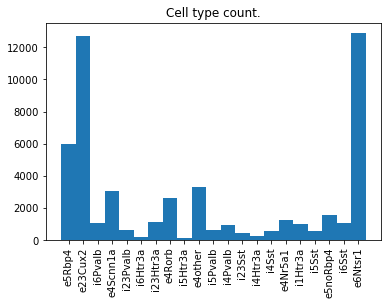

In [3]:
plt.hist(dataset.cell_type_ids, bins=np.arange(-0.5, dataset.num_cell_types, 1))
plt.xticks(np.arange(dataset.num_cell_types), dataset.cell_type_labels, rotation='vertical')
plt.title('Cell type count.')
plt.show()

### Split into train/val/test sets

In [5]:
# first, we split the population of neurons into three subsets
# the split is startified, i.e. the cell types are balanced across classes
# Note: The split can be done before the aggregation so that diverse cells are present in all subsets.
dataset.split_cell_train_val_test(test_size=0.2, val_size=0.2, seed=1234)

# next, the trial are temporally split
dataset.split_trial_train_val_test(test_size=0.2, val_size=0.2, temp=True, seed=1234)

## Sample populations of neurons!
Currently when sampling populations, a fixed number of cells are sampled for each cell type

##### To select a random population in a random trial
The number of spikes for each cell is going to be different: X is thus an array of arrays

In [6]:
X, y, m = dataset.sample(mode='train', sampler='U10')
print('Spike times set:', X.shape)
print('Spike times for one cell:', X[0])
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

Spike times set: (170,)
Spike times for one cell: []
Trial id: 46, Orientation: 45.0


##### To change the number of samples per class, use `sampler=U60` to get 60 cells per cell type.
Note: Some cell types have fewer than 20 cells (across all split sets), so currently max is 20

In [7]:
X, y, m = dataset.sample(mode='train', sampler='U20')
print('Spike times set:', X.shape)
print('Spike times for one cell:', X[0])
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

Spike times set: (340,)
Spike times for one cell: [75.99023579 76.10052696 76.57889407 76.66877992 77.07210705 77.18587717
 77.57837871 77.66672386]
Trial id: 25, Orientation: 225.0


## Process the data
### Compute interspike interval

In [8]:
X, y, m = dataset.sample(mode='train', sampler='U20', transform='interspike_interval')
print('Spike times set:', X.shape)
print('Spike times for one cell:', X[0])
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

Spike times set: (340,)
Spike times for one cell: [0.1711059  0.22102686 0.16671843 0.37504354 0.28985888 0.13134619
 0.11007204 0.12699176]
Trial id: 35, Orientation: 315.0


### Compute firing rate
Now the matrix you get is square!
But first you need to define binning parameters

In [9]:
dataset.set_bining_parameters(bin_size=10e-3)  # 10ms

X, y, m = dataset.sample(mode='train', sampler='U20', transform='firing_rate')
print('Firing rate matrix:', X.shape)
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))


Firing rate matrix: (300, 340)
Trial id: 22, Orientation: 90.0


## More about sampling
### Fixing the population and randomly sampling the trial
Use cell_random_seed

In [22]:
X, y, m = dataset.sample(mode='train', sampler='U20', cell_random_seed=40) #cell_random_seed defines cell selection
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

Trial id: 10, Orientation: 225.0


##### Fixing the trial and randomly sampling the population
Use trial_random_seed or trial_id

In [23]:
# select trial
X, y, m = dataset.sample(mode='train', sampler='U20', trial_id=18)
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

# fix trial random seed
X, y, m = dataset.sample(mode='train', sampler='U20', trial_random_seed=1)
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

X, y, m = dataset.sample(mode='train', sampler='U20', trial_random_seed=1)
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

Trial id: 18, Orientation: 315.0
Trial id: 37, Orientation: 180.0
Trial id: 37, Orientation: 180.0


##### Switch between train/val/test sets

In [20]:
X, y, m = dataset.sample(mode='test', sampler='U20')
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

Trial id: 87, Orientation: 270.0


Note that fixing the random seed for train and test won't actually give you the same population or the same trials for
obvious reasons.

However, if you want to get a population from the "training" set and test it in a "validation" trial. You can use
mode='val_time' (or 'test_time'). In this case make sure to fix the cell_random_seed to get the same population from your train set.

In [21]:
X, y, m = dataset.sample(mode='val_time', sampler='U20', cell_random_seed=40)
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

Trial id: 70, Orientation: 135.0


Similarly, use fix time and change population, by using mode='val_cell' or 'test_cell':

In [44]:
X, y, m = dataset.sample(mode='val_cell', sampler='U20', trial_random_seed=2)
print('Trial id: %d, Orientation: %r' %(m['trial_id'], m['orientation']))

Trial id: 40, Orientation: 180.0


# Compute covariance

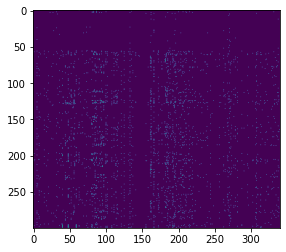

In [32]:
X, y, m = dataset.sample(mode='train', sampler='U20', transform='firing_rate')

plt.imshow(X)
plt.show()

##### Raw data

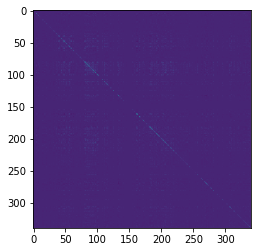

In [33]:
cov = compute_cov(X.T)
plt.imshow(cov)
plt.show()

##### Divide by max

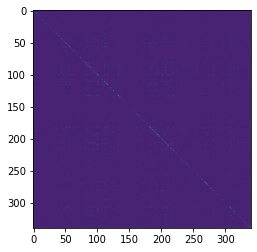

In [34]:
cov = compute_cov(X.T, scaler=sklearn.preprocessing.MaxAbsScaler)
plt.imshow(cov)
plt.show()

##### Zero-score

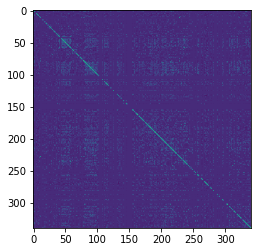

In [35]:
cov = compute_cov(X.T, scaler=sklearn.preprocessing.StandardScaler)
plt.imshow(cov)
plt.show()

### Compute edge distribution

In [42]:
compute_edge_dist(cov)

array([[340,   0,   0, ...,   0,   0,   0],
       [128,  24,  20, ...,   0,   0,   0],
       [110,   9,   9, ...,   0,   0,   0],
       ...,
       [182,  25,  12, ...,   0,   0,   0],
       [139,  22,   2, ...,   0,   0,   0],
       [110,   4,   4, ...,   0,   0,   0]])